In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [2]:
# load and examine the data
path1='/content/drive/MyDrive/relax_challenge/takehome_user_engagement.csv'
path2='/content/drive/MyDrive/relax_challenge/takehome_users.csv'
engagement_df = pd.read_csv(path1,encoding='latin-1')
user_df = pd.read_csv(path2,encoding='latin-1')
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


##Data Wrangling

In [3]:
#let's see the detail of each features
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
# create a feature of user history
# convert both time features into datetime
user_df['creation_time'] = pd.to_datetime(
    user_df['creation_time'], format='%Y-%m-%d %H:%M:%S')
user_df['last_session_creation_time'] = pd.to_datetime(
    user_df['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
user_df['history'] = user_df['last_session_creation_time'] - user_df['creation_time']
user_df['history'] = user_df['history'].dt.days
# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(user_df['creation_time'])
user_df['account_age'] = latest - user_df['creation_time']
user_df['account_age'] = user_df['account_age'].dt.days
# drop the two original columns
user_df = user_df.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [7]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(
    engagement_df['user_id'].nunique(), len(engagement_df)
))

There were 8823 users and 207917 total logins


In [8]:
user_df.head()

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,account_age
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,38
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,196
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,437
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,374
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,498


In [9]:
#convert time stamp to datetime
engagement_df.time_stamp = pd.to_datetime(engagement_df.time_stamp)
#extract week and year from time_stamp
engagement_df['week-year'] = engagement_df['time_stamp'].dt.strftime('%U-%Y')

usage = engagement_df.groupby(['user_id', 'week-year']).size().reset_index().rename(columns={0:'count'})

usage['adopted'] = usage['count']>=3

adopted_users = list(usage[usage.adopted==True].user_id.unique())

user_df['adopted_user'] = user_df.object_id.apply(lambda x: x in adopted_users).astype(int)

users_clean = user_df.drop(['name','email'],axis=1)
users_clean = users_clean.set_index('object_id')


In [10]:
# Check on the higher risk/more defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} feature:'.format(feature))
    print(user_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



#EDA

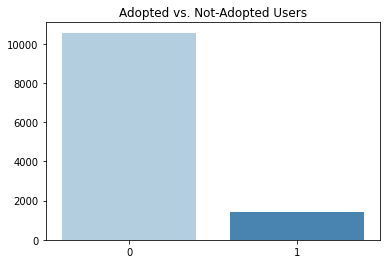

In [11]:
# Take another look at the distribution of the target class
sns.barplot(x = list(users_clean['adopted_user'].value_counts().index), y = users_clean['adopted_user'].value_counts(), palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

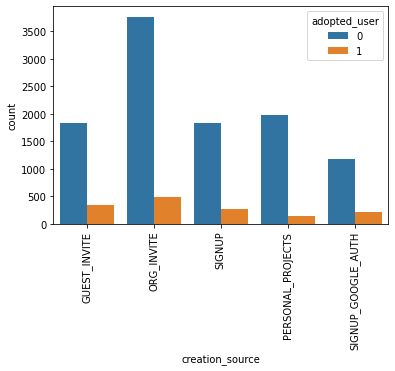

In [12]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=users_clean, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [13]:
# doesn't look like there was much difference among creation sources
# let's do a chi2 test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(users_clean['creation_source'], users_clean['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 92.30452600767856	p = 4.264119734593792e-19


In [14]:
# hmm, chi2 test significant, but how much was the difference
users_clean.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.152566
ORG_INVITE            0.115186
PERSONAL_PROJECTS     0.066793
SIGNUP                0.126018
SIGNUP_GOOGLE_AUTH    0.150181
Name: adopted_user, dtype: float64

K, slightly higher "adopted user" rate in guest_invite and personal_projects, that makes sense because users who got invite probably was collaborting with others, and users who have personal projects are likely to have more personal interest that make them more engaged.

In [15]:
users_clean.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [16]:
# check mailing list and marketing drip
users_clean.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.118588
1    0.121576
Name: adopted_user, dtype: float64

In [17]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[users_clean[col]==1, target]
    opted_out = df.loc[users_clean[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(users_clean, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.437008654790529, p = 0.6621050713958125


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
users_clean.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.119220
1    0.119978
Name: adopted_user, dtype: float64

In [19]:
z_test(users_clean, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.0912189795228396, p = 0.9273185943462832


There was really no difference between users who signed up or not for mailing list and marketing drip.

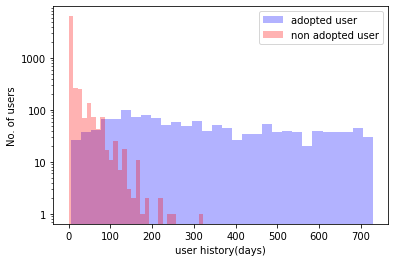

In [20]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[users_clean['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[users_clean['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(users_clean, 'history', 'user history(days)')

Pretty clear that users with long history are more likely to be adopted users.

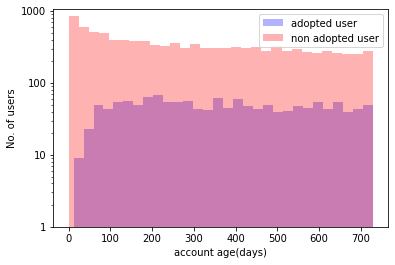

In [21]:
plot_hist_days(users_clean, 'account_age', 'account age(days)')

Not surprisingly, the adoption rate is lower in very new accounts. Other than that, the adoption rate didn't change much over the past two years.



#Encoding

In [22]:
# #One-hot encoding of creation_source. Drop first to avoid multicollinearity
# source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
# df = pd.concat([users_clean,source_dummies],axis=1)

# #drop original column
# df = df.drop(['creation_source'],axis=1)#One-hot encoding of creation_source. Drop first to avoid multicollinearity
# source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
# df = pd.concat([users_clean,source_dummies],axis=1)

# #drop original column
# df = df.drop(['creation_source'],axis=1)

In [23]:
# # make dummy variable for creation source
# creation_source = pd.get_dummies(users_clean['creation_source'], drop_first=True)
# model_data = pd.concat([users_clean, creation_source], axis=1).drop('creation_source', axis=1)
# y = model_data['adopted_user']
# X = model_data.drop('adopted_user', axis=1)
# # though account_age and history have different scales than other features,
# # I plan to use random forest model, which is not affectd by the different scales
# # no need to scale the data
# # create training and testing sets
# from sklearn.model_selection import train_test_split
# Xtrain, Xtest, ytrain, ytest = train_test_split(
#     X, y, stratify=y, random_state=42)

In [24]:
users_clean=users_clean.drop(['history','invited_by_user_id'], axis=1)
users_clean.isnull().sum()

creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
account_age                   0
adopted_user                  0
dtype: int64

In [25]:
# One-hot-encode creation_source
df_encoded = pd.get_dummies(users_clean, columns = ['creation_source'])


X = df_encoded.drop('adopted_user', axis=1)
y = df_encoded['adopted_user']

# Split into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, 
                                                           random_state=2007, stratify=users_clean['adopted_user'])

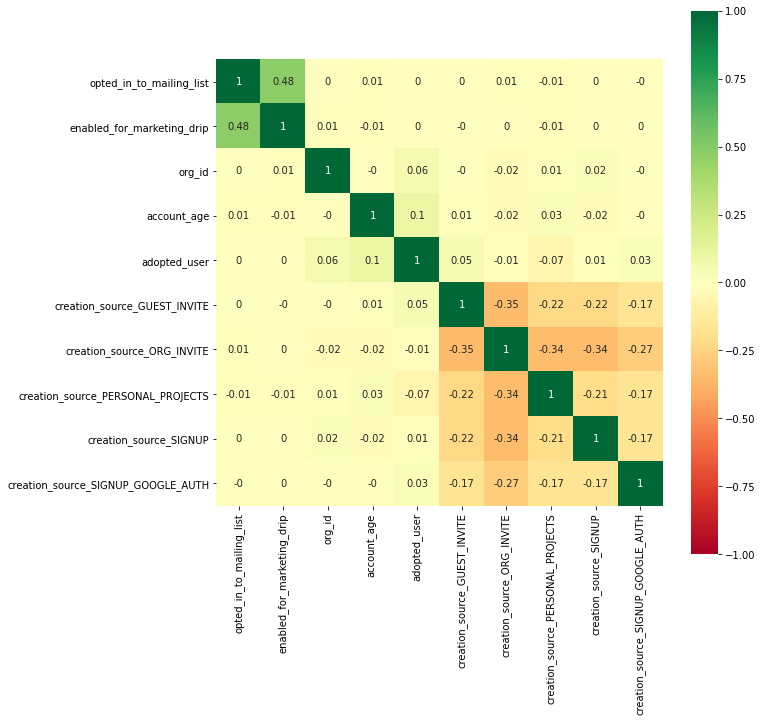

In [26]:
plt.figure(figsize=(10,10))
_ = sns.heatmap(df_encoded.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)


In [27]:
#SMOTE oversampling to balance out the classes

from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)
# X_resampled, y_resampled = X_train, y_train
#ADASYN().fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0, 7398), (1, 7206)]


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


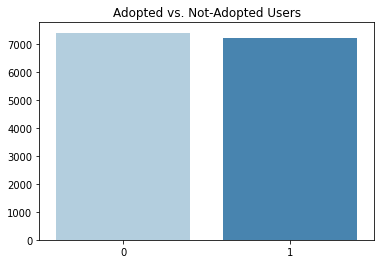

In [28]:
# Take a look at the distribution of the enhanced target class
sns.countplot(y_resampled, palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

#Modeling

In [29]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [31]:
names = []
scores = []
for name, model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

  Name     Score
0  KNN  0.864444
1  SVC  0.880556
2   LR  0.880556
3   DT  0.781667
4  GNB  0.880556
5   RF  0.858889
6   GB  0.879722


In [32]:
names = []
scores = []
for name, model in tqdm(models):
    
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
 14%|█▍        | 1/7 [00:00<00:03,  1.75it/s]/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
 29%|██▊       | 2/7 [00:15<00:24,  4.80s/it]/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
 43%|████▎     | 3/7 [00:16<00:15,  3.8

  Name     Score
0  KNN  0.866500
1  SVC  0.880667
2   LR  0.880667
3   DT  0.790333
4  GNB  0.880667
5   RF  0.862250
6   GB  0.880417


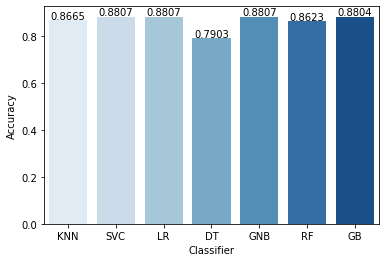

In [33]:
# Visualize model model scores
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val, palette='Blues')
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

Train and tune a single model.

In [34]:
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.7254            0.84s
         2           0.7206            0.83s
         3           0.7162            0.81s
         4           0.7125            0.79s
         5           0.7093            0.76s
         6           0.7065            0.75s
         7           0.7040            0.73s
         8           0.7017            0.72s
         9           0.6997            0.70s
        10           0.6979            0.69s
        20           0.6861            0.59s
        30           0.6806            0.53s
        40           0.6754            0.45s
        50           0.6715            0.37s
        60           0.6676            0.30s
        70           0.6642            0.22s
        80           0.6603            0.15s
        90           0.6573            0.07s
       100           0.6536            0.00s
Train Score: 0.881
Test Score: 0.88


In [35]:

# TP / FP 
confusion_matrix(y_test, clf.predict(X_test))

array([[3167,    3],
       [ 430,    0]])

In [36]:
#Examine the model feature importance.

clf.feature_importances_.shape

(9,)

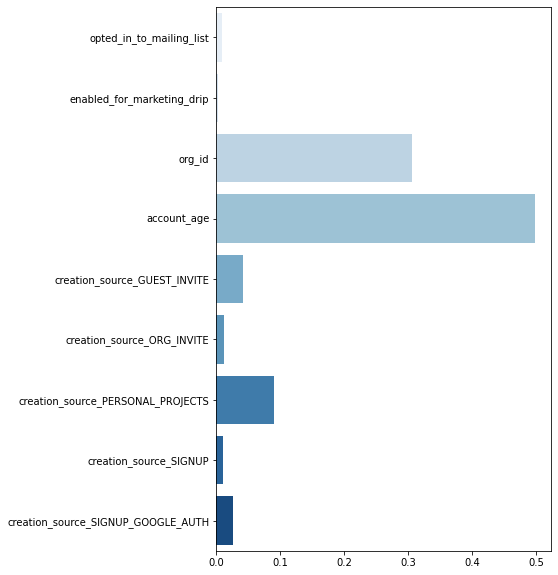

In [37]:

features = pd.Series(clf.feature_importances_, index=X.columns)

plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=clf.feature_importances_, palette='Blues')

In [38]:
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
account_age,0.498937
org_id,0.306690
creation_source_PERSONAL_PROJECTS,0.090800
creation_source_GUEST_INVITE,0.042067
creation_source_SIGNUP_GOOGLE_AUTH,0.026612
creation_source_ORG_INVITE,0.011972
creation_source_SIGNUP,0.010795
opted_in_to_mailing_list,0.009330
enabled_for_marketing_drip,0.002797


In [39]:
# As can be seen above the most important feature is the most recent log-in time.

# now lets try some hyperparameter tunning.


param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                                min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=2007), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [40]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.cv_results_

({'mean_fit_time': array([0.33729982, 0.4765233 , 0.65354223, 0.80765257, 0.97777467,
         1.14423742, 1.13333416]),
  'mean_score_time': array([0.01343031, 0.01439328, 0.01629119, 0.01764488, 0.01708851,
         0.02114291, 0.02333393]),
  'mean_test_score': array([0.65621666, 0.65319926, 0.64892369, 0.64851206, 0.64591258,
         0.64249185, 0.64088214]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'rank_test_score': array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
  'split0_test_score': array([0.65640034, 0.65086149, 0.64640541, 0.64493581, 0.64386486,
         0.63735811, 0.63592568]),
  'split1_test_score': array([0.63511486, 0.63237669, 0.62822

In [41]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=60, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=2007), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.cv_results_, gsearch2.best_params_, gsearch2.cv_results_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.88604231, 0.82152939, 0.7958838 , 0.7832953 , 0.73887448,
         1.07264462, 0.98249311, 0.92011704, 0.86335902, 0.84824467,
         1.25478497, 1.11888375, 1.02503614, 0.94718909, 0.8763782 ,
         1.40898757, 1.19232321, 1.0553731 , 0.9689404 , 0.91272678,
         1.5287293 , 1.23847303, 1.08849673, 1.00559611, 0.92891531,
         1.62757635, 1.28088312, 1.14790587, 0.95375147, 0.83648133]),
  'mean_score_time': array([0.01798429, 0.01532931, 0.01546149, 0.01925988, 0.01557603,
         0.02167492, 0.01784501, 0.02019763, 0.02136607, 0.01527781,
         0.01726594, 0.02015676, 0.02032552, 0.01835046, 0.01960115,
         0.02071648, 0.02099357, 0.02005792, 0.01858854, 0.01600552,
         0.02323403, 0.0223177 , 0.01685801, 0.02139173, 0.01678505,
         0.02151546, 0.01927276, 0.02103343, 0.0179842 , 0.012498  ]),
  'mean_test_score': array([0.64458375, 0.65124576, 0.6478482 , 0.65165109, 0.64903579,
         0.64083879, 0.64121238, 0.64680357,

In [42]:
clf_tuned = GradientBoostingClassifier(learning_rate=0.05, 
                                       n_estimators=70, 
                                       max_features='auto', 
                                       subsample=0.85,
                                       max_depth= 6,
                                       min_samples_split= 800,
                                       random_state=2007,
                                       verbose=True)

In [43]:
clf_tuned.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7339           0.0022            0.99s
         2           0.7243           0.0026            0.82s
         3           0.7272           0.0016            0.76s
         4           0.7088           0.0020            0.72s
         5           0.7145           0.0023            0.70s
         6           0.7151           0.0021            0.68s
         7           0.7188           0.0021            0.66s
         8           0.7091           0.0010            0.64s
         9           0.7017           0.0014            0.63s
        10           0.7004           0.0009            0.63s
        20           0.6935           0.0003            0.54s
        30           0.6836          -0.0000            0.43s
        40           0.6726          -0.0002            0.33s
        50           0.6703           0.0000            0.22s
        60           0.6571          -0.0003            0.11s
       

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=800,
                           min_weight_fraction_leaf=0.0, n_estimators=70,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2007, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

In [44]:
clf_tuned = GradientBoostingClassifier(learning_rate=0.05, 
                                       n_estimators=70, 
                                       max_features='auto', 
                                       subsample=0.85,
                                       max_depth= 6,
                                       min_samples_split= 800,
                                       random_state=2007,
                                       verbose=True)

In [45]:
clf_tuned.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7339           0.0022            0.82s
         2           0.7243           0.0026            0.74s
         3           0.7272           0.0016            0.71s
         4           0.7088           0.0020            0.71s
         5           0.7145           0.0023            0.70s
         6           0.7151           0.0021            0.68s
         7           0.7188           0.0021            0.65s
         8           0.7091           0.0010            0.65s
         9           0.7017           0.0014            0.63s
        10           0.7004           0.0009            0.62s
        20           0.6935           0.0003            0.52s
        30           0.6836          -0.0000            0.41s
        40           0.6726          -0.0002            0.31s
        50           0.6703           0.0000            0.22s
        60           0.6571          -0.0003            0.11s
       

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=800,
                           min_weight_fraction_leaf=0.0, n_estimators=70,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2007, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

In [46]:
print('Train Score:', round(clf_tuned.score(X_train,y_train),3))
print('Test Score:', round(clf_tuned.score(X_test,y_test),3))

Train Score: 0.881
Test Score: 0.881


# Conclusion:
With approximatly 81% of the userbase no considered non adoptive users, we have an obvious area for improvment in user engagment. 